In [1]:
import numpy as np
from grss import prop, utils
from astropy.time import Time
import matplotlib.pyplot as plt
import requests
from tqdm.auto import tqdm

Please note that the Gaia ESA Archive has been rolled back to version 3.7. Please find the release notes at https://www.cosmos.esa.int/web/gaia-users/archive/release-notes


In [2]:
# pick your favorite NEOCP object of the day, number of orbits to propagate, and the final time for the propagation
body_id = 'CDDK512'
n_orbits = 1000
tf = Time('2025-06-17 00:00:00', scale='tdb', format='iso')

In [3]:
# use NEOCP API to get the 1,000 orbits
# https://ssd-api.jpl.nasa.gov/scout.api?tdes={body_id}&orbits=1
assert 1 <= n_orbits <= 1000, 'n_orbits must be between 1 and 1000'
url = f'https://ssd-api.jpl.nasa.gov/scout.api?tdes={body_id}&orbits=true&n-orbits={n_orbits}'
response = requests.get(url)
if response.status_code != 200:
    raise RuntimeError(f'Failed to fetch data: {response.status_code}')
data = response.json()

In [4]:
# parse the Scout orbits, convert them as needed, and put them into a list of dictionaries
orbits = []
all_fields = data['orbits']['fields']
my_fields_keys = ('epoch', 'ec', 'qr', 'tp', 'om', 'w', 'inc')
my_fields_vals = [all_fields.index(f) for f in my_fields_keys]
my_fields = dict(zip(my_fields_keys, my_fields_vals))
for scout_orbit in data['orbits']['data']:
    tmp = {}
    for key, val in my_fields.items():
        num = float(scout_orbit[val])
        if key in {'om', 'w', 'inc'}:
            # convert angles from degrees to radians
            num = np.deg2rad(num)
        if key in {'epoch', 'tp'}:
            # convert epoch and tp from JD to MJD
            num -= 2400000.5
        tmp[key] = num
    orbits.append(tmp)

In [5]:
# Times at which to output information
if tf.tdb.mjd < orbits[0]['epoch']:
    num_points = max(int(orbits[0]['epoch']-tf.tdb.mjd), 2)
    t_eval = np.linspace(tf.tdb.mjd, orbits[0]['epoch'], num_points)
else:
    num_points = max(int(tf.tdb.mjd-orbits[0]['epoch']), 2)
    t_eval = np.linspace(orbits[0]['epoch'], tf.tdb.mjd, num_points)
t_eval = Time(['2025-06-14', '2025-06-15'], scale='utc', format='iso').utc.mjd  # Example times for evaluation
# Flag to specify if t_eval is in UTC or TDB
t_eval_utc = True
timescale = 'UTC' if t_eval_utc else 'TDB'
# Flag to specify whether to output apparent states instead of geometric
eval_apparent_state = True
# Flag to specify whether to use a more accurate converged light time correction when computing apparent states
converged_lt = True
# Specify the observer coordinates (user-defined)
stn_info = (500,) + (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) # (500=earth and then inertial geocentric J2000 equatorial position and velocity in au and au/day)
observer_info = [stn_info]*len(t_eval) # use same observer for all times

In [6]:
# check that t_eval is in ascending order
assert np.all(np.diff(t_eval) > 0), 't_eval must be in ascending order'

In [7]:
for i, orbit in tqdm(enumerate(orbits), total=len(orbits), desc='Integrating orbits'):
    # GRSS uses MJD times and radian angles for orbit input
    ec = orbit['ec']
    qr = orbit['qr']
    tp = orbit['tp']
    om = orbit['om']
    w = orbit['w']
    inc = orbit['inc']
    com_elems = np.array([ec, qr, tp, om, w, inc])

    # Nongravitational parameters according to Marsden et al. (1973) model (usually these are NOT used for NEOCP objects)
    # A1, A2, A3 + coefficients/exponents for the power laws
    ng_params = prop.NongravParameters()
    ng_params.a1 = orbit.get('a1', 0.0)
    ng_params.a2 = orbit.get('a2', 0.0)
    ng_params.a3 = orbit.get('a3', 0.0)
    ng_params.alpha = 1.0
    ng_params.k = 0.0
    ng_params.m = 2.0
    ng_params.n = 0.0
    ng_params.r0_au = 1.0

    # Specify the integration parameters
    t0 = Time(orbit['epoch'], scale='tdb', format='mjd')
    prop_sim = prop.PropSimulation(f"{body_id} ephemeris", t0.tdb.mjd, 440, utils.default_kernel_path)
    if tf.tdb.mjd < t0.tdb.mjd:
        # GRSS interpolates on the fly, so for backward propagation we need to reverse the time and observer information
        prop_sim.set_integration_parameters(tf.tdb.mjd, t_eval[::-1], t_eval_utc, eval_apparent_state, converged_lt, observer_info[::-1])
    else:
        prop_sim.set_integration_parameters(tf.tdb.mjd, t_eval, t_eval_utc, eval_apparent_state, converged_lt, observer_info)
    prop_sim.evalMeasurements = True
    # Add the body to the simulation
    body = prop.IntegBody(f'{body_id} instance {i}', t0.tdb.mjd, mass=0.0, radius=0.0, cometaryState=com_elems, ngParams=ng_params)
    prop_sim.add_integ_body(body)
    # Add some evaluation margin in case the light-time correction puts the evaluation time outside the integration time span
    prop_sim.tEvalMargin = 0.1
    # integrate the body
    prop_sim.integrate()

    # Get the plane of the sky coordinates
    obs = np.array(prop_sim.opticalObs)/3600.0 # arcseconds to degrees
    pos = {
        f't_eval_{timescale}': t_eval,
        'ra': obs[:, 0],
        'dec': obs[:, 1],
    }
    pos['cos_dec'] = np.cos(np.deg2rad(pos['dec']))
    orbit['pos'] = pos

Integrating orbits:   0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
all_ra = np.array([orbit['pos']['ra'] for orbit in orbits]).T
all_dec = np.array([orbit['pos']['dec'] for orbit in orbits]).T
all_cos_dec = np.array([orbit['pos']['cos_dec'] for orbit in orbits]).T

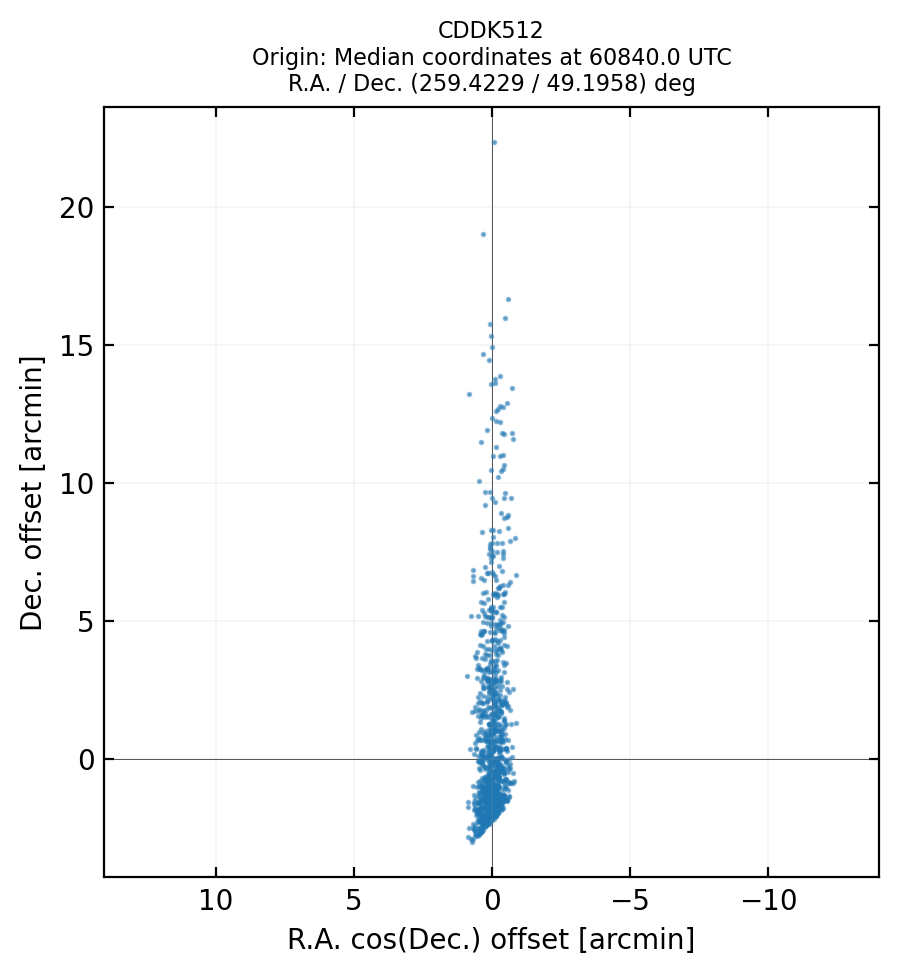

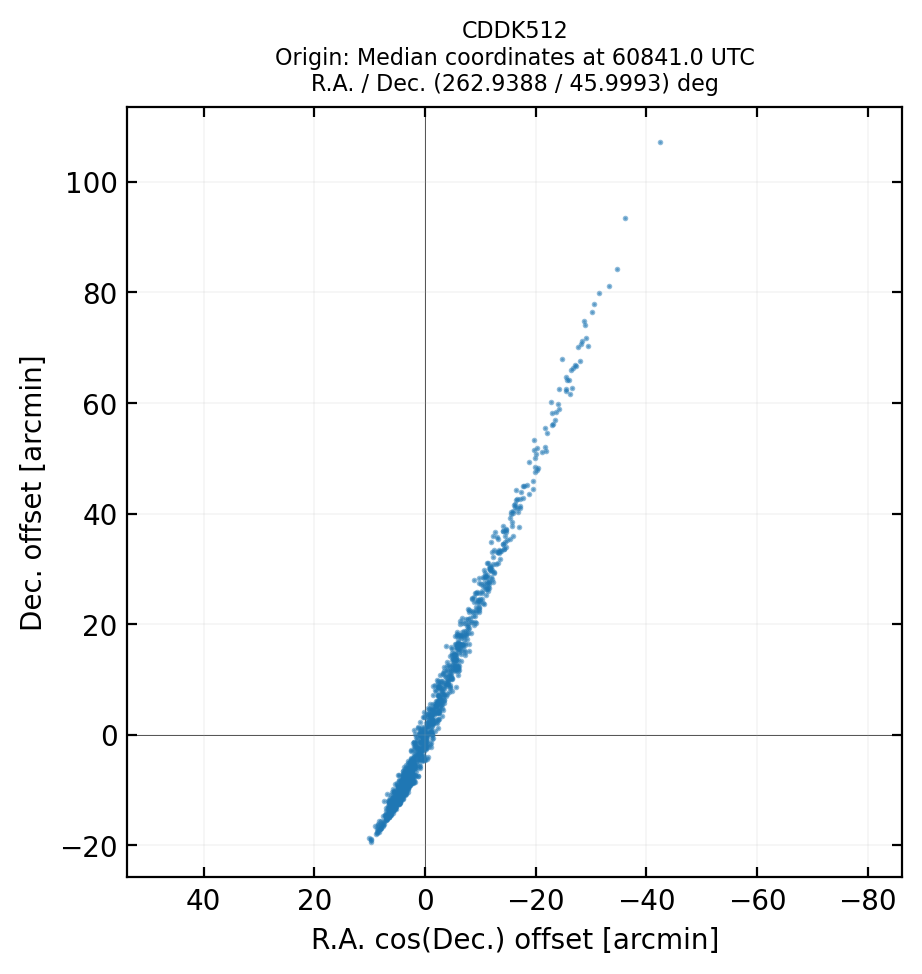

In [9]:
for time_idx in [0,1]: # indices of t_eval to plot
    ra_vals = all_ra[time_idx]
    dec_vals = all_dec[time_idx]
    cos_dec_vals = all_cos_dec[time_idx]
    median_ra = np.median(ra_vals)
    median_dec = np.median(dec_vals)
    # wrap RA offsets to [-180*60, 180*60] arcmin
    ra_offsets = (ra_vals - median_ra) * cos_dec_vals * 60  # convert to arcmin
    ra_offsets = (ra_offsets + 180 * 60) % (360 * 60) - 180 * 60
    # wrap Dec offsets to [-90*60, 90*60] arcmin
    dec_offsets = (dec_vals - median_dec) * 60  # convert to arcmin
    dec_offsets = (dec_offsets + 90 * 60) % (180 * 60) - 90 * 60
    plt.figure(figsize=(5, 5), dpi=200)
    plt.scatter(ra_offsets, dec_offsets, s=1, c='C0', alpha=0.5)
    plt.xlabel('R.A. cos(Dec.) offset [arcmin]')
    plt.ylabel('Dec. offset [arcmin]')
    plt.axis('equal')
    plt.gca().invert_xaxis()
    plt.title(f'{body_id}\nOrigin: Median coordinates at {t_eval[time_idx]} {timescale}\nR.A. / Dec. ({median_ra:.4f} / {median_dec:.4f}) deg', fontsize=8)
    plt.grid(which='both', linestyle='-', linewidth=0.075)
    plt.axvline(0, color='k', linestyle='-', linewidth=0.25, zorder=-100)
    plt.axhline(0, color='k', linestyle='-', linewidth=0.25, zorder=-100)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.show()